In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report,accuracy_score,ConfusionMatrixDisplay,confusion_matrix,precision_score,recall_score,roc_curve,roc_auc_score,balanced_accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
import datetime
from dataclasses import dataclass
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.ndimage import gaussian_filter1d
from itertools import combinations as comb
from pyts.image import RecurrencePlot
import PIL
from sklearn.utils import class_weight
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,StratifiedKFold
from unidecode import unidecode

In [3]:
train_data = pd.read_csv('./dataset/dataset_1/train_motion_data.csv')
test_data = pd.read_csv('./dataset/dataset_1/test_motion_data.csv')
print(train_data.shape)
print(test_data.shape)

(3644, 8)
(3084, 8)


In [4]:
train_data.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.000000,0.000000,0.000000,0.059407,-0.174707,0.101938,NORMAL,3581629
1,-1.624864,-1.082492,-0.204183,-0.028558,0.051313,0.135536,NORMAL,3581630
2,-0.594660,-0.122410,0.220502,-0.019395,-0.029322,0.087888,NORMAL,3581630
3,0.738478,-0.228456,0.667732,0.069791,-0.029932,0.054902,NORMAL,3581631
4,0.101741,0.777568,-0.066730,0.030696,-0.003665,0.054902,NORMAL,3581631


In [5]:
train_data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3644.000000,3.644000e+03
mean,0.040467,-0.073418,0.008271,0.001593,-0.001273,0.007949,3.582707e+06
std,0.985653,0.903408,0.985061,0.066918,0.126205,0.115687,6.421479e+02
min,-4.636523,-4.699795,-7.143998,-0.751822,-1.587028,-1.236468,3.581629e+06
25%,-0.550695,-0.592540,-0.558464,-0.028558,-0.053756,-0.029398,3.582121e+06
50%,0.003931,-0.080833,0.002262,0.001985,-0.001833,0.002978,3.582702e+06
75%,0.595987,0.452401,0.556157,0.031918,0.051313,0.040852,3.583270e+06
max,4.985548,4.245151,5.171739,0.849255,1.679879,1.190500,3.583791e+06


In [6]:
train_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [7]:
train_data=train_data.sort_values(by='Timestamp')
print(train_data.Timestamp.unique().shape)

(1968,)


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 256.2+ KB


In [9]:
train_data.Timestamp.value_counts().describe()

count    1968.000000
mean        1.851626
std         0.355561
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

In [10]:
print(train_data.columns)

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')


In [11]:
train_data['Timestamp'] = train_data['Timestamp'].astype('int')
train_data['Class'] = train_data['Class'].astype('category')
train_data['class_code'] = train_data['Class'].cat.codes

In [12]:
var_columns = ['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns = ['class_code','Class']

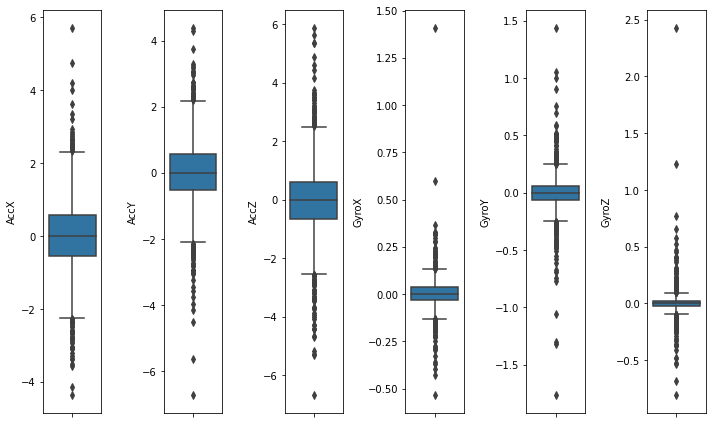

In [14]:
index = (train_data.Timestamp.value_counts()>1).index
measument1 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff = measument1-measument2
fig,axes = plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

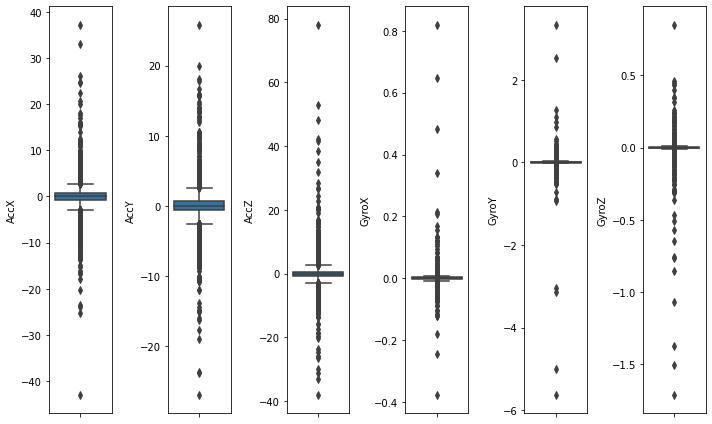

In [15]:
index = (train_data.Timestamp.value_counts()>1).index
measument1 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff = (measument1-measument2)/0.5*(measument2+measument1)
fig,axes = plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

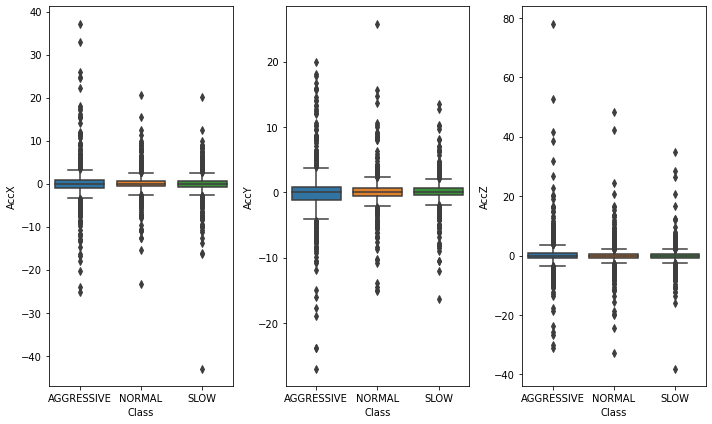

In [16]:
index = (train_data.Timestamp.value_counts()>1).index
measument1 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff = (measument1-measument2)/0.5*(measument2+measument1)
diff = diff.reset_index().merge(train_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns = [column for column in var_columns if 'Acc' in column]
fig,axes = plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

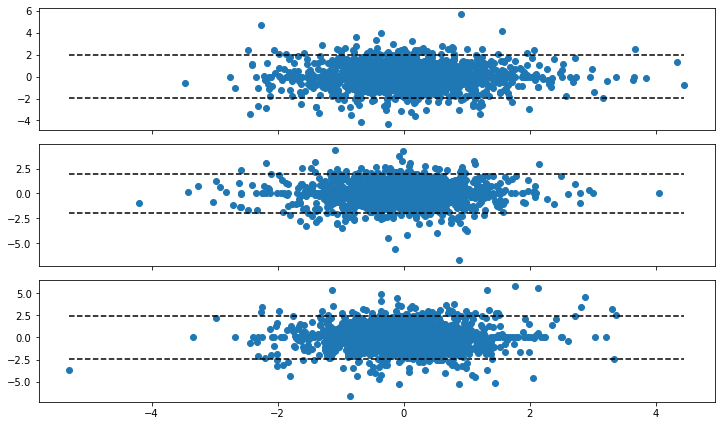

In [17]:
index = (train_data.Timestamp.value_counts()>1).index
measument1 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff = measument1-measument2
mean = (measument1+measument2)*0.5
used_columns = [column for column in var_columns if 'Acc' in column]
fig,axes = plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x = mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()

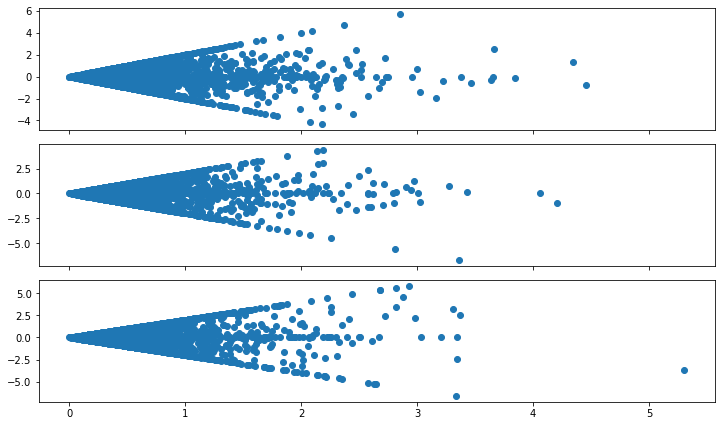

In [18]:
index = (train_data.Timestamp.value_counts()>1).index
measument1 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2 = train_data.set_index(train_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff = measument1-measument2
mean = (np.abs(measument1)+np.abs(measument2))*0.5
used_columns = [column for column in var_columns if 'Acc' in column]
fig,axes = plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()

In [19]:
train_data['Acc_mod'] = 0.5*(train_data['AccX']**2+train_data['AccY']**2+train_data['AccZ']**2)
var_columns.append('Acc_mod')

<AxesSubplot:>

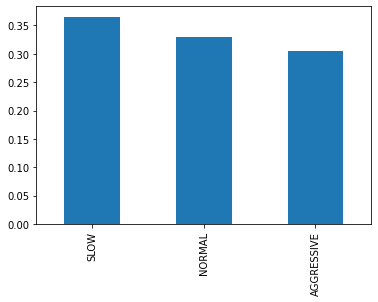

In [20]:
train_data['Class'].value_counts(normalize=True).plot(kind='bar')

In [21]:
missing_seconds=set(train_data['Timestamp'].unique()).difference(set(range(train_data['Timestamp'].min(),train_data['Timestamp'].max()+1)))
missing_seconds

set()

In [22]:
avaible_seconds=train_data.Timestamp.unique()

for second in missing_seconds:
    new_index=len(train_data)+1
    train_data.loc[new_index,['Timestamp']]=[second]
    train_data.loc[new_index,var_columns]=[np.nan]*len(var_columns)
   
    for offset in range(1,11):
        filled=False
        if second-offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second-offset,label_columns]
            filled=True
            break
        elif second+offset in avaible_seconds:
            train_data.loc[new_index,label_columns]=train_data.drop_duplicates('Timestamp').set_index('Timestamp').loc[second+offset,label_columns]
            filled=True
            break

    if not filled: print('Method did not work')
    train_data.loc[new_index,label_columns]=[np.nan]*len(label_columns)
    
train_data=train_data.sort_values('Timestamp').reset_index(drop=True)
train_data[var_columns]=train_data[var_columns].interpolate(method='polynomial',order=5)[var_columns]=train_data[var_columns].interpolate(method='linear')

In [23]:
train_data['Class'].map({'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}).value_counts()

green    1331
blue     1200
red      1113
Name: Class, dtype: int64

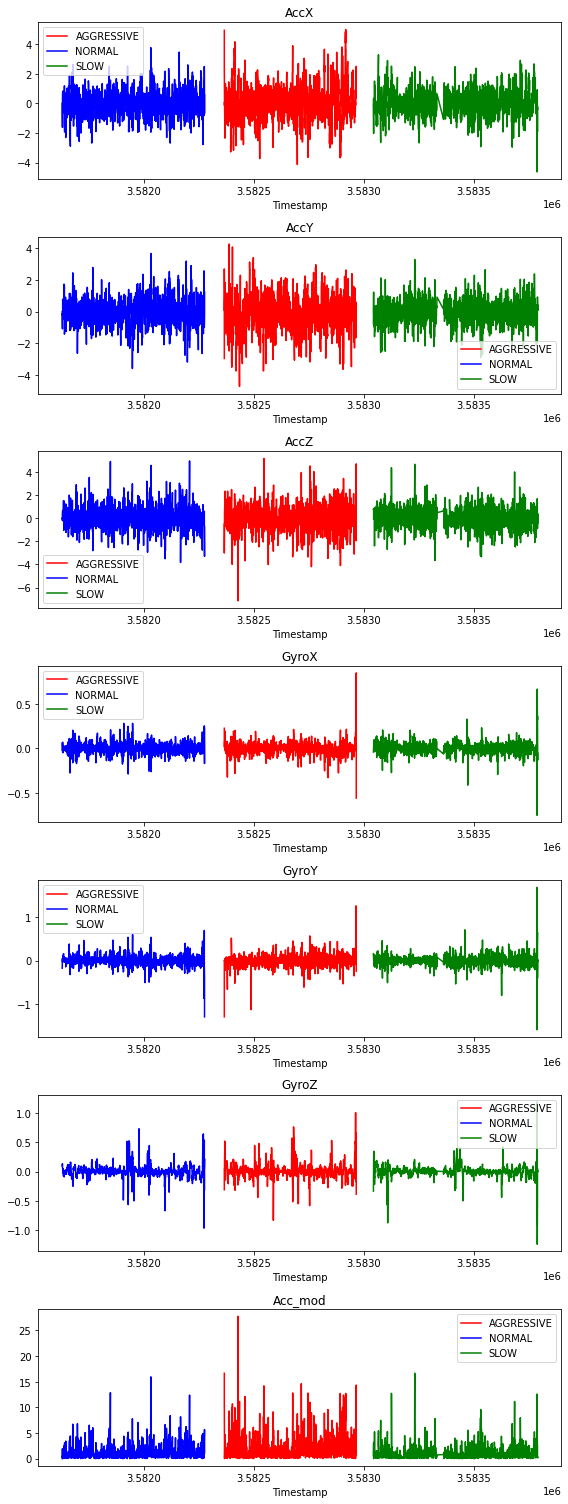

In [24]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=train_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

In [25]:
def fourier_analysis(data,fft_ax,psd_ax,prefix=''):
    fft=np.fft.fft(data)
    freq=np.fft.fftfreq(len(data),d=1)

    fft_ax.plot(freq,fft.real,color='red',alpha=0.5,label='real')
    fft_ax.plot(freq,fft.imag,color='blue',alpha=0.6,label='imag')
    fft_ax.set_xlim(left=0)
    fft_ax.set_title(prefix+' FFT')
    fft_ax.legend()
    psd=(1/len(data))*(fft.real**2+fft.imag**2)
    psd_ax.set_title(prefix+' PSD')
    psd_ax.plot(freq,psd,color='blue',alpha=0.7)
    psd_ax.set_xlim(left=-0.01)

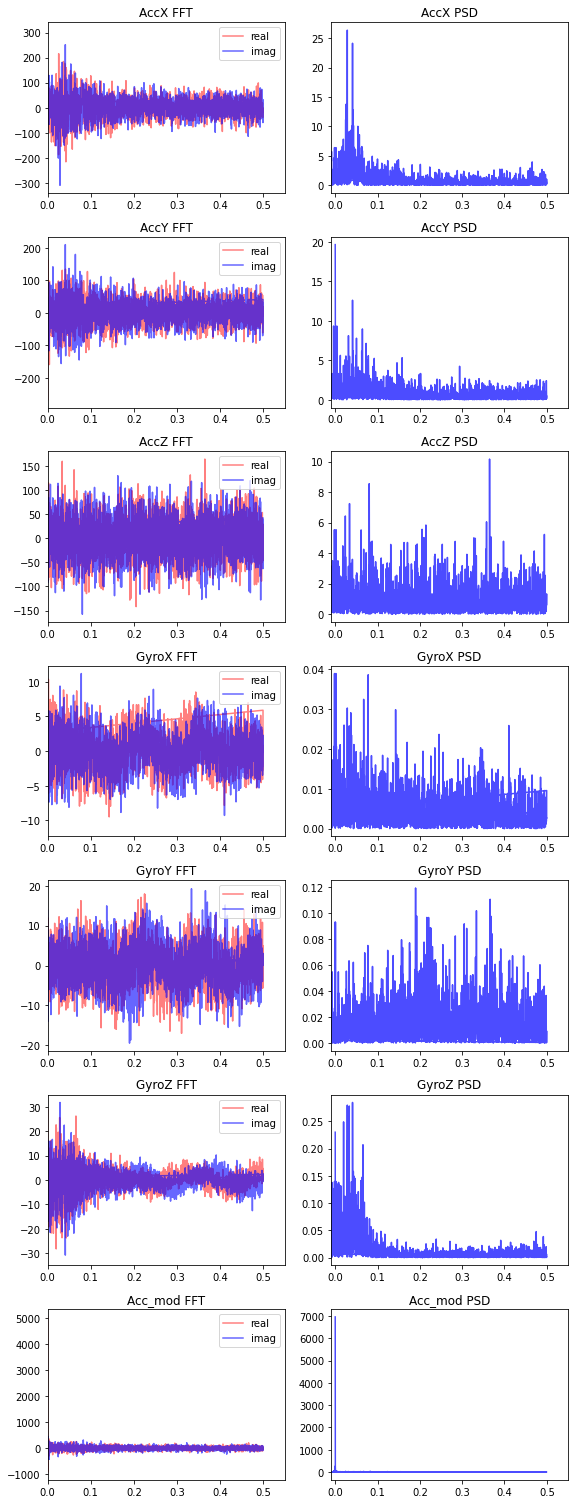

In [26]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(train_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

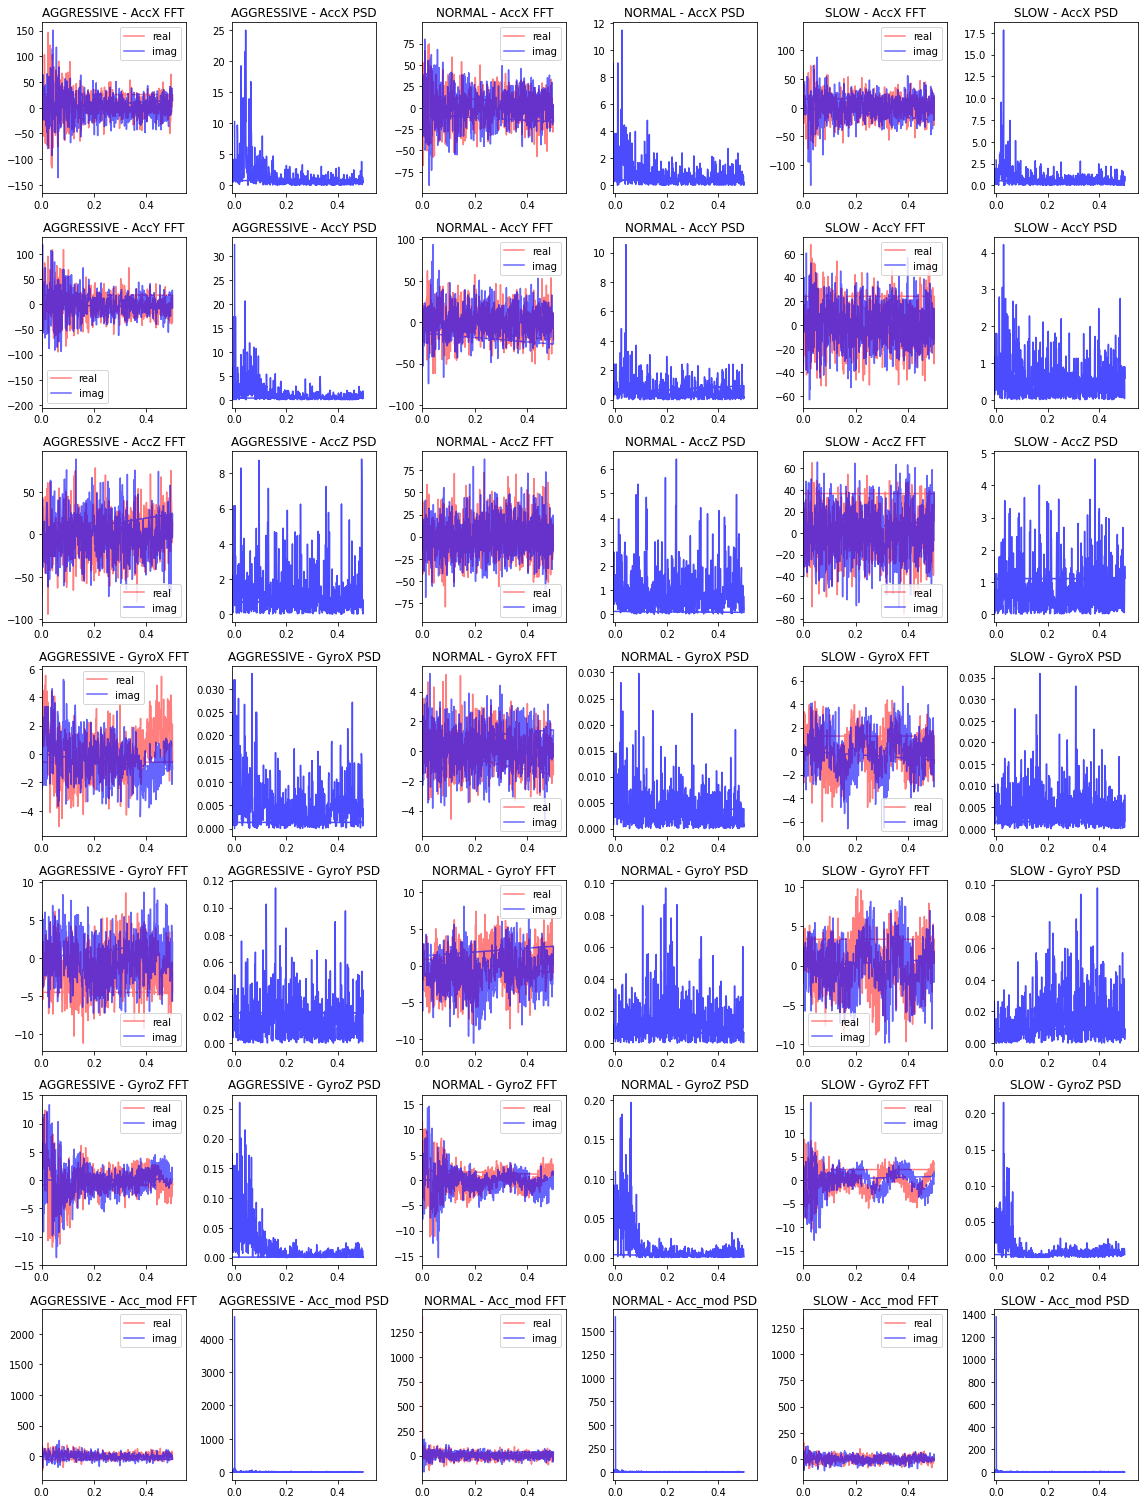

In [27]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

In [33]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

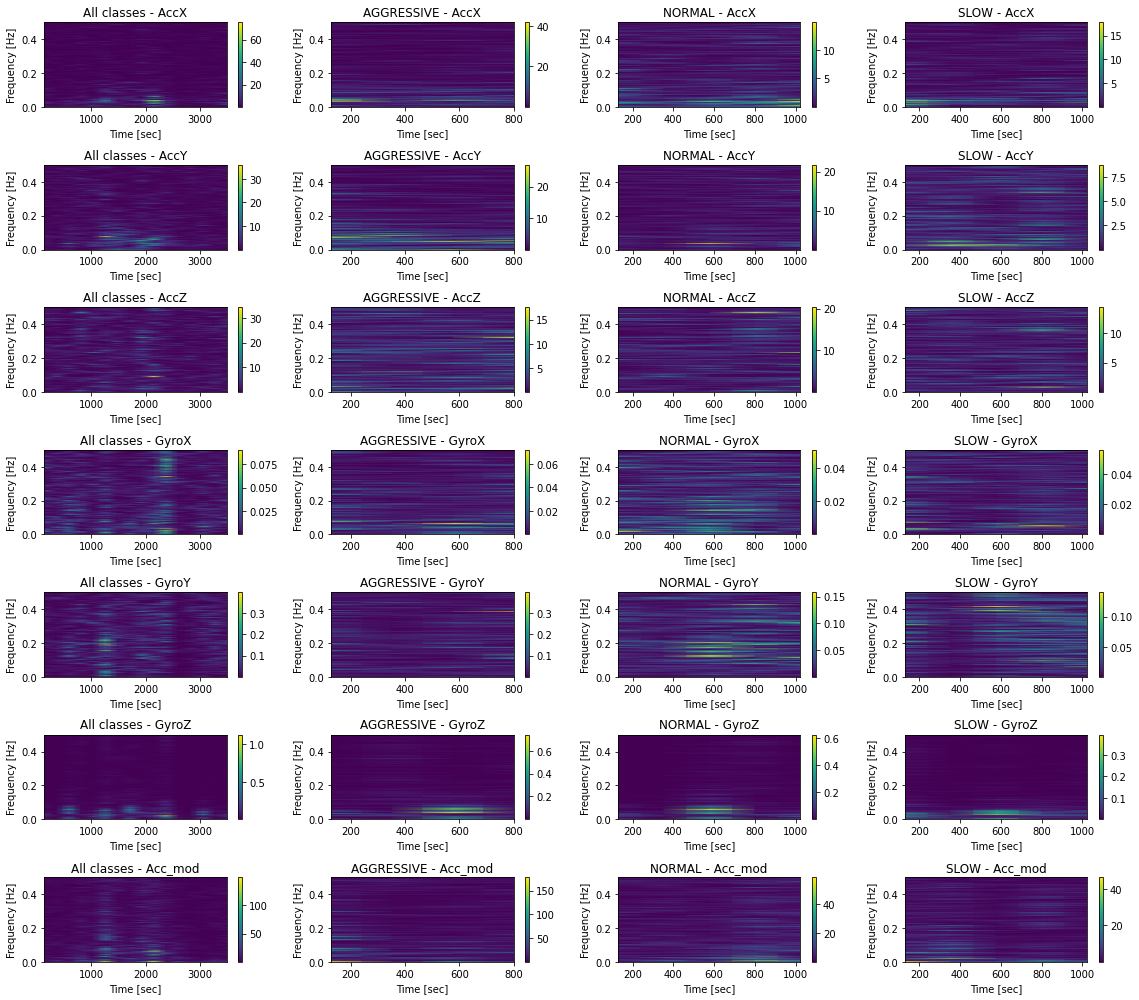

In [34]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=train_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=train_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

In [36]:
test_data.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Timestamp
0,0.758194,-0.217791,0.457263,0.000000,0.000000,0.000000,AGGRESSIVE,818922
1,0.667560,-0.038610,0.231416,-0.054367,-0.007712,0.225257,AGGRESSIVE,818923
2,2.724449,-7.584121,2.390926,0.023824,0.013668,-0.038026,AGGRESSIVE,818923
3,2.330950,-7.621754,2.529024,0.056810,-0.180587,-0.052076,AGGRESSIVE,818924
4,2.847215,-6.755621,2.224640,-0.031765,-0.035201,0.035277,AGGRESSIVE,818924


In [37]:
test_data.describe()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Timestamp
count,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000,3084.000000
mean,0.106234,-0.131791,0.045011,0.003192,0.001452,0.011472,819830.000324
std,0.968089,0.904398,0.997625,0.066636,0.120963,0.113535,525.760733
min,-4.854163,-7.621754,-6.106982,-0.514959,-1.309466,-0.976315,818922.000000
25%,-0.408916,-0.625868,-0.461438,-0.024435,-0.045739,-0.027031,819338.000000
50%,0.051892,-0.096929,0.054154,0.001222,-0.000993,0.002291,819832.500000
75%,0.579148,0.393118,0.575119,0.028100,0.043601,0.035888,820292.250000
max,5.864980,4.308813,5.564037,1.490511,1.707598,0.719447,820709.000000


In [38]:
test_data.isna().sum()

AccX         0
AccY         0
AccZ         0
GyroX        0
GyroY        0
GyroZ        0
Class        0
Timestamp    0
dtype: int64

In [39]:
test_data=test_data.sort_values(by='Timestamp')
print(test_data.Timestamp.unique().shape)

(1667,)


In [40]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3084 entries, 0 to 3083
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3084 non-null   float64
 1   AccY       3084 non-null   float64
 2   AccZ       3084 non-null   float64
 3   GyroX      3084 non-null   float64
 4   GyroY      3084 non-null   float64
 5   GyroZ      3084 non-null   float64
 6   Class      3084 non-null   object 
 7   Timestamp  3084 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 216.8+ KB


In [41]:
test_data.Timestamp.value_counts().describe()

count    1667.000000
mean        1.850030
std         0.357149
min         1.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: Timestamp, dtype: float64

In [42]:
print(test_data.columns)

Index(['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Class',
       'Timestamp'],
      dtype='object')


In [43]:
test_data['Timestamp']=test_data['Timestamp'].astype('int')
test_data['Class']=test_data['Class'].astype('category')
test_data['class_code']=test_data['Class'].cat.codes

In [44]:
var_columns=['AccX','AccY','AccZ','GyroX','GyroY','GyroZ']
label_columns=['class_code','Class']

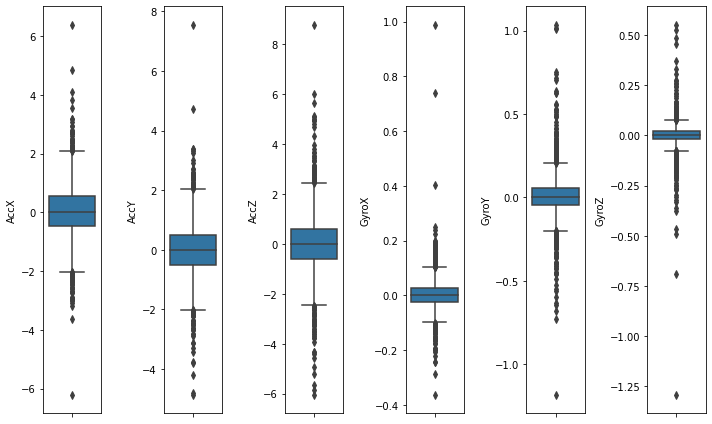

In [45]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

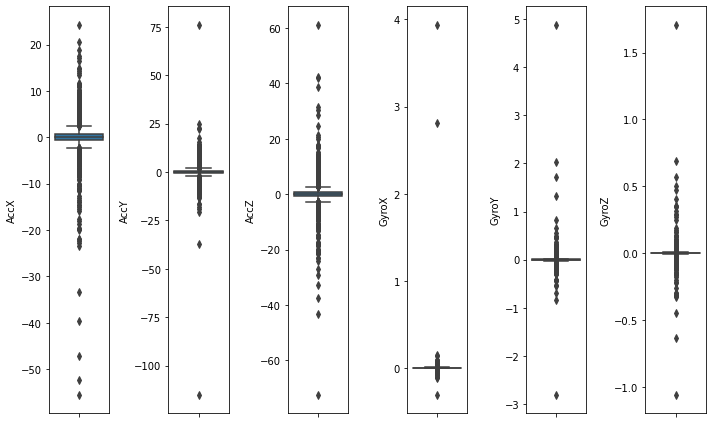

In [46]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
fig,axes=plt.subplots(1,len(var_columns),figsize=(10,6))
for column,ax in zip(var_columns,axes.flatten()):    
    sns.boxplot(data=diff,y=column,ax=ax)
plt.tight_layout()

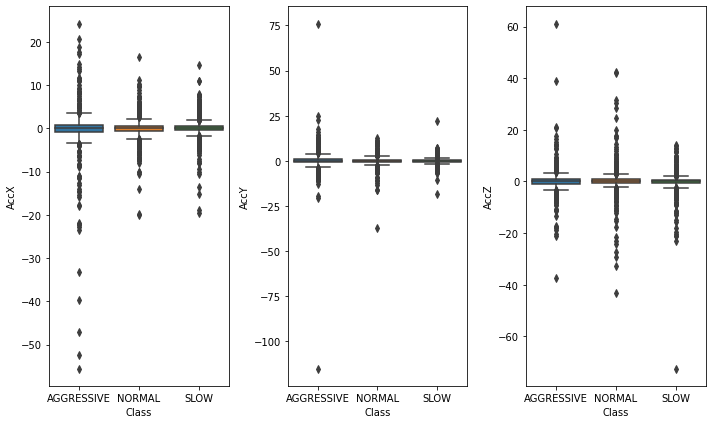

In [47]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=(measument1-measument2)/0.5*(measument2+measument1)
diff=diff.reset_index().merge(test_data.drop_duplicates('Timestamp')[['Timestamp','Class']],right_on='Timestamp',left_on='index')
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(1,len(used_columns),figsize=(10,6))
for column,ax in zip(used_columns,axes.flatten()):
    sns.boxplot(data=diff,y=column,ax=ax,x='Class')
plt.tight_layout()

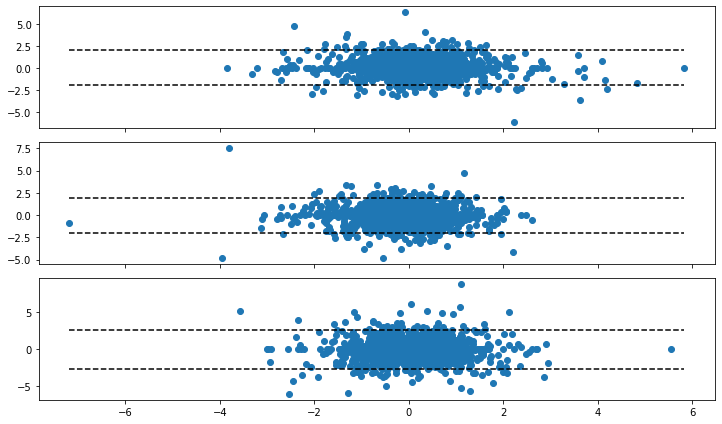

In [48]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(measument1+measument2)*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])
    ax.hlines(np.mean(diff[column])+2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
    ax.hlines(np.mean(diff[column])-2*np.std(diff[column]),mean[used_columns].min().min(),mean[used_columns].max().max(),linestyles='dashed',color='black')
plt.tight_layout()

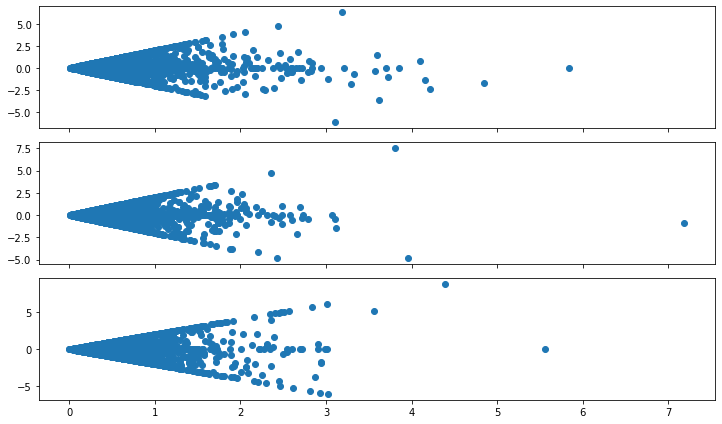

In [49]:
index=(test_data.Timestamp.value_counts()>1).index
measument1=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='first',subset='Timestamp').loc[index,var_columns]
measument2=test_data.set_index(test_data.Timestamp).drop_duplicates(keep='last',subset='Timestamp').loc[index,var_columns]
diff=measument1-measument2
mean=(np.abs(measument1)+np.abs(measument2))*0.5
used_columns=[column for column in var_columns if 'Acc' in column]
fig,axes=plt.subplots(len(used_columns),1,figsize=(10,6),sharex=True)
for column,ax in zip(used_columns,axes.flatten()):    
    ax.scatter(x=mean[column],y=diff[column])

plt.tight_layout()

In [50]:
test_data['Acc_mod']=0.5*(test_data['AccX']**2+test_data['AccY']**2+test_data['AccZ']**2)
var_columns.append('Acc_mod')

<AxesSubplot:>

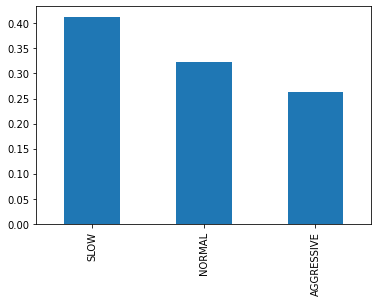

In [51]:
test_data['Class'].value_counts(normalize=True).plot(kind='bar')

In [52]:
missing_seconds=set(test_data['Timestamp'].unique()).difference(set(range(test_data['Timestamp'].min(),test_data['Timestamp'].max()+1)))
missing_seconds

set()

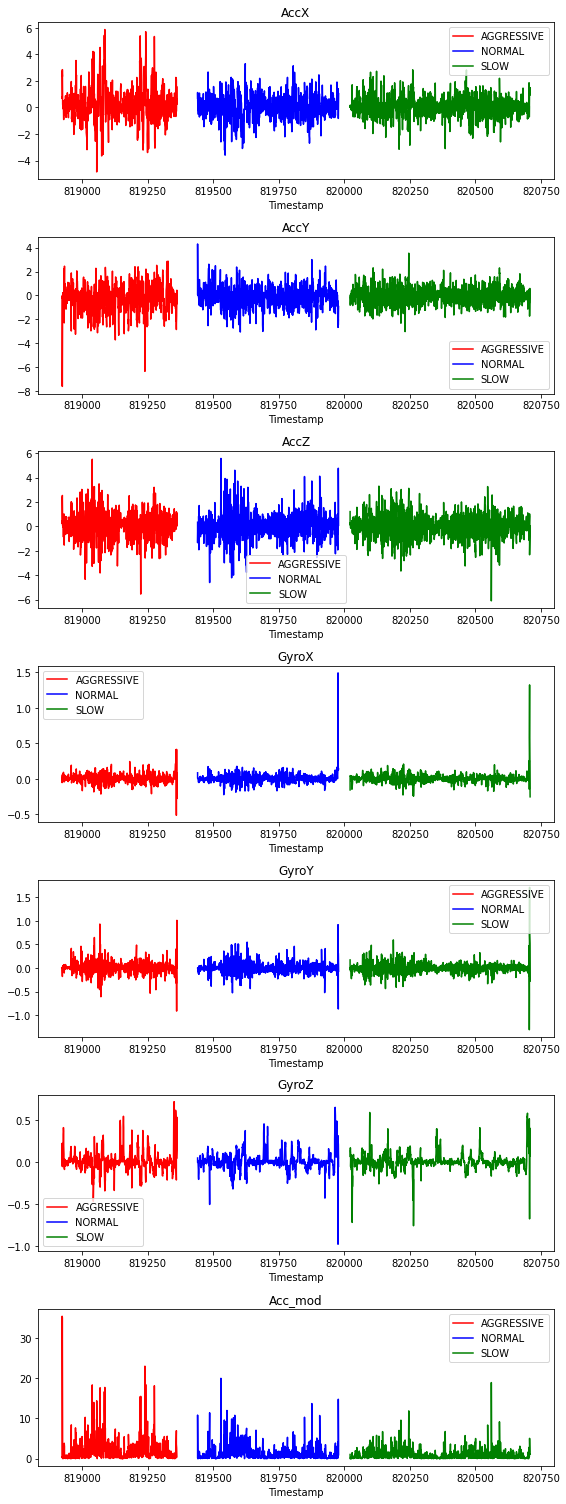

In [53]:
fig,axes=plt.subplots(len(var_columns),1,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes.flatten(),var_columns):
    grouped=test_data.groupby('Class')
    color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
    for key,group in grouped:
        group.plot(ax=ax,x='Timestamp',y=column,label=key,color=color[key])
    ax.set_title(column)
plt.tight_layout()

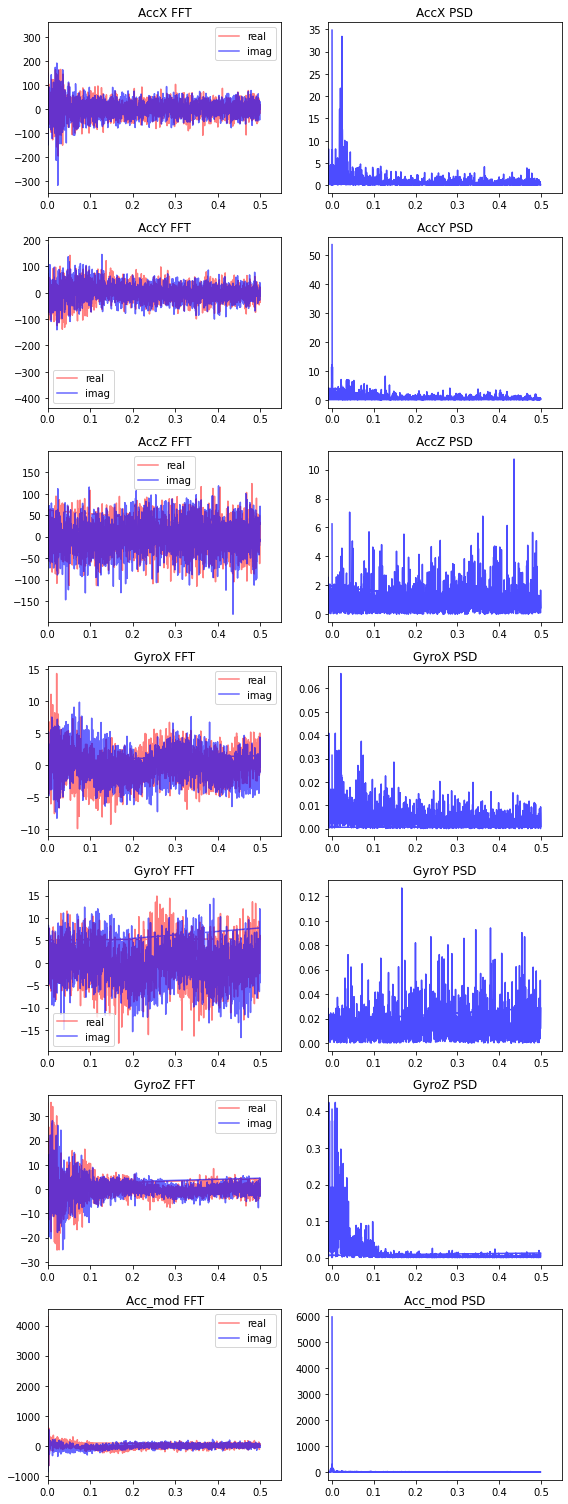

In [54]:
fig,axes=plt.subplots(len(var_columns),2,figsize=(8,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    fourier_analysis(test_data[column],ax[0],ax[1],prefix=column)
plt.tight_layout()

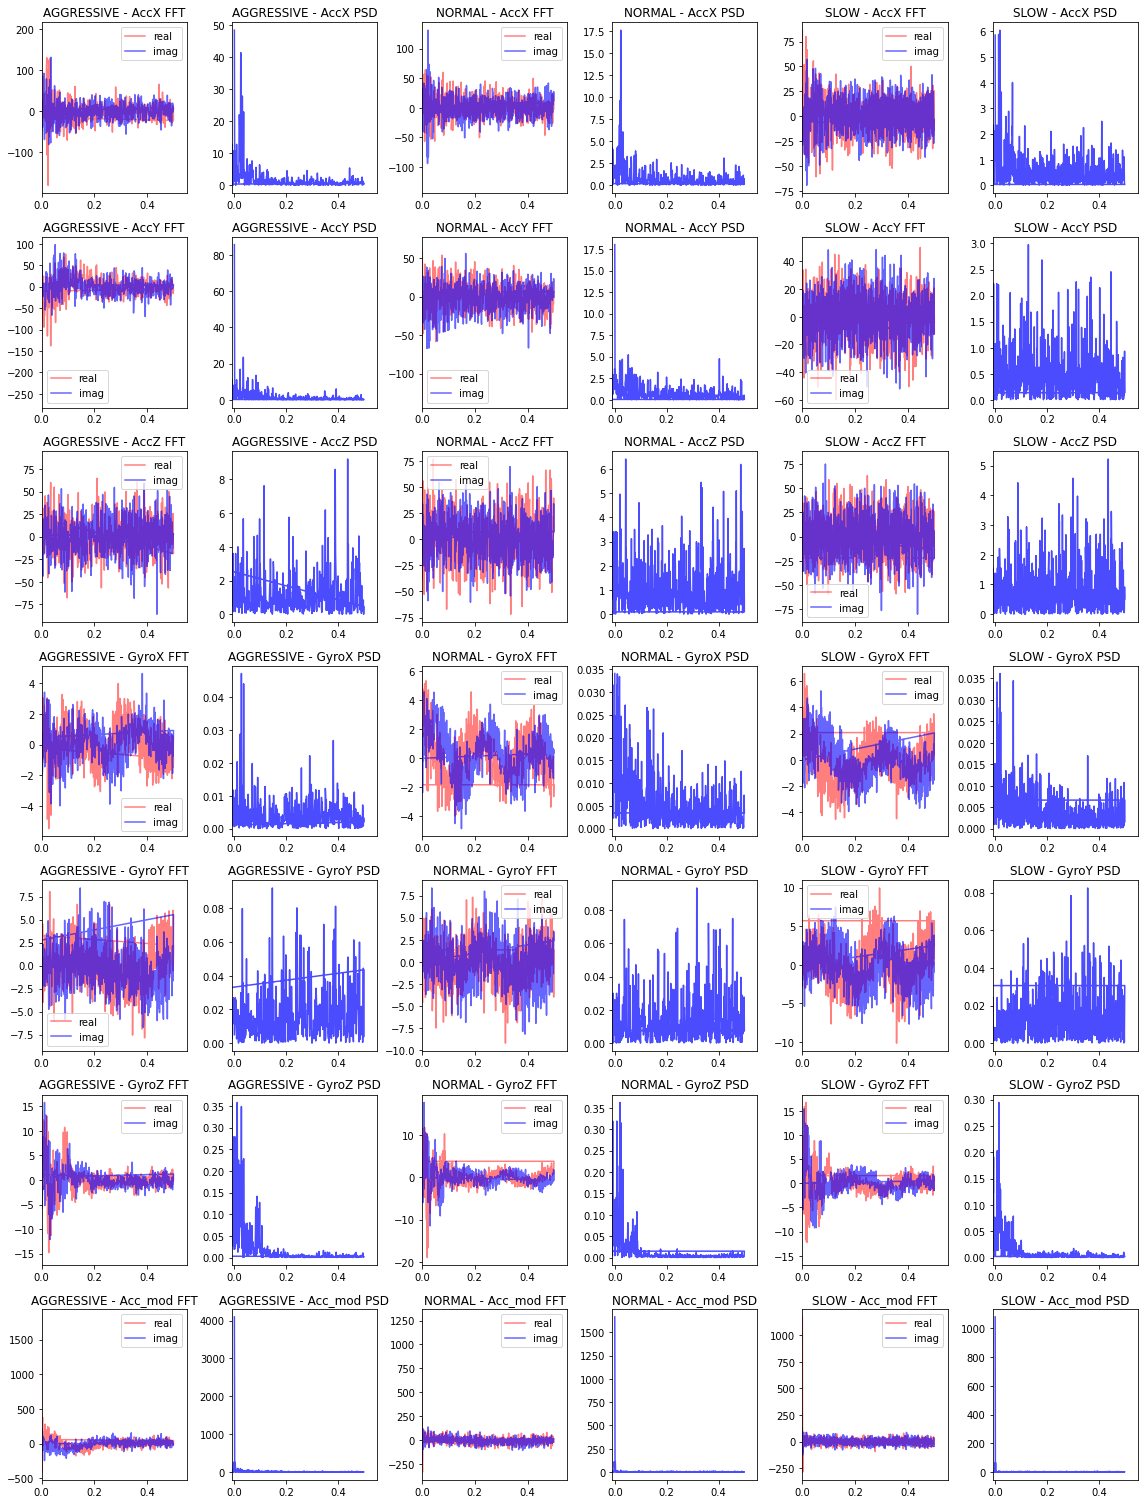

In [55]:
fig,axes=plt.subplots(len(var_columns),6,figsize=(16,3*len(var_columns)))

for ax,column in zip (axes,var_columns):
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=grouped.get_group(key)[column]
        fourier_analysis(data,ax[groupd_index*2],ax[groupd_index*2+1],prefix=f'{key} - {column}')
plt.tight_layout()

In [56]:
def spectogram_analysis(data,ax,prefix=''):
    f, t, Sxx = signal.spectrogram(data, 1)
    im=ax.pcolormesh(t, f, Sxx, shading='gouraud')
    ax.set_ylabel('Frequency [Hz]')
    ax.set_xlabel('Time [sec]')
    ax.set_title(prefix)
    plt.colorbar(im,ax=ax)

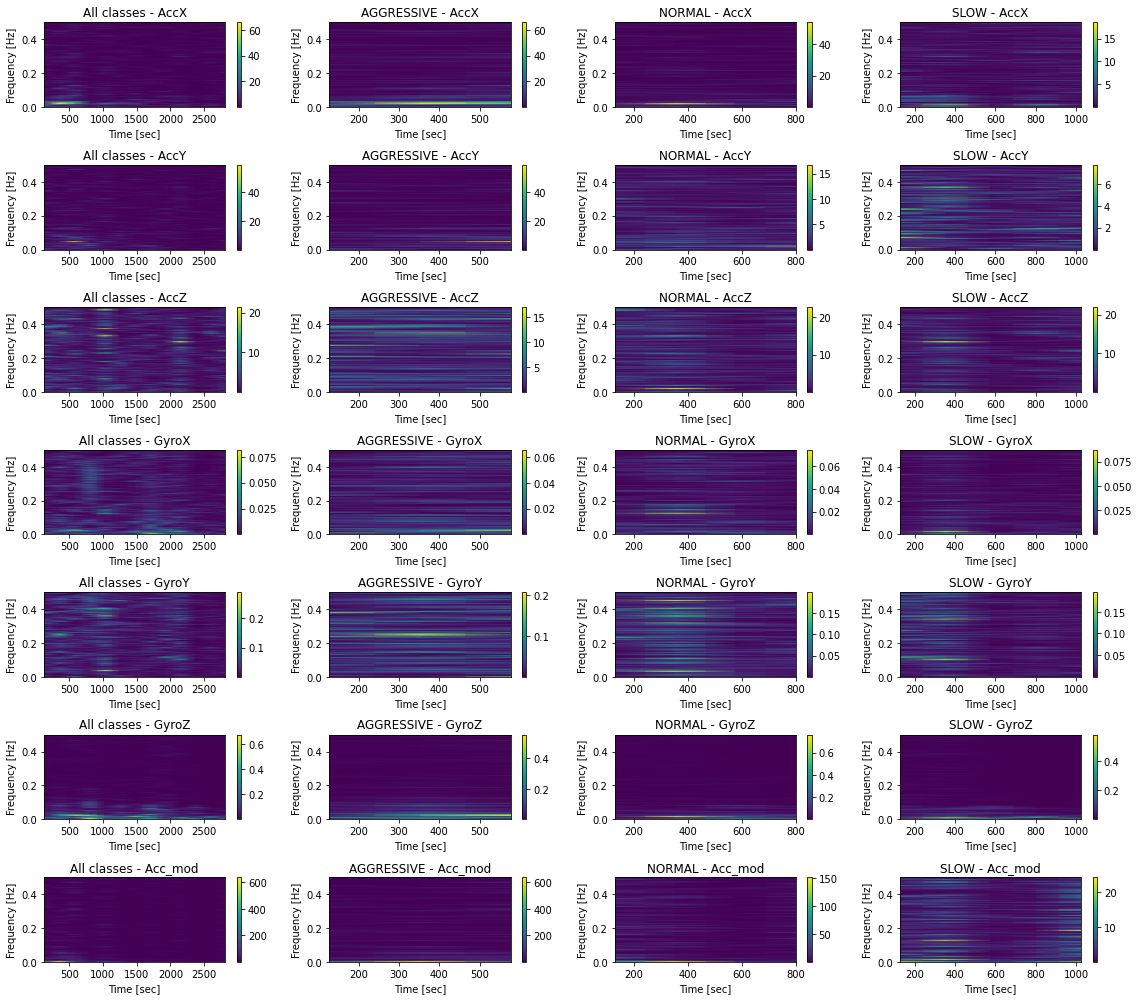

In [57]:
fig,axes=plt.subplots(len(var_columns),4,figsize=(16,2*len(var_columns)))

for ax,column in zip (axes,var_columns):
    data=test_data[column]
    spectogram_analysis(data,ax[0],f'All classes - {column}')
    grouped=test_data.groupby('Class')
    for groupd_index,(key,group) in enumerate(grouped):
        data=group[column]
        spectogram_analysis(data,ax[groupd_index+1],prefix=f'{key} - {column}')
plt.tight_layout()

In [58]:
def split_numeric_categoric_data(df):
    return df[var_columns],df[label_columns]


def rooling_average(df:pd.DataFrame,window):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.rolling(window).mean()    
    return pd.concat([df_smoothed,df_labels],axis=1)

def exponential_smoothing(df:pd.DataFrame,alpha):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.ewm(alpha=alpha).mean()
    return pd.concat([df_smoothed,df_labels],axis=1)
   
def gaussian_smoothing(df:pd.DataFrame,window,std):
    df_numeric,df_labels=split_numeric_categoric_data(df)
    df_smoothed=df_numeric.rolling(window,win_type='gaussian',center=True).mean(std=std)
    return pd.concat([df_smoothed,df_labels],axis=1)

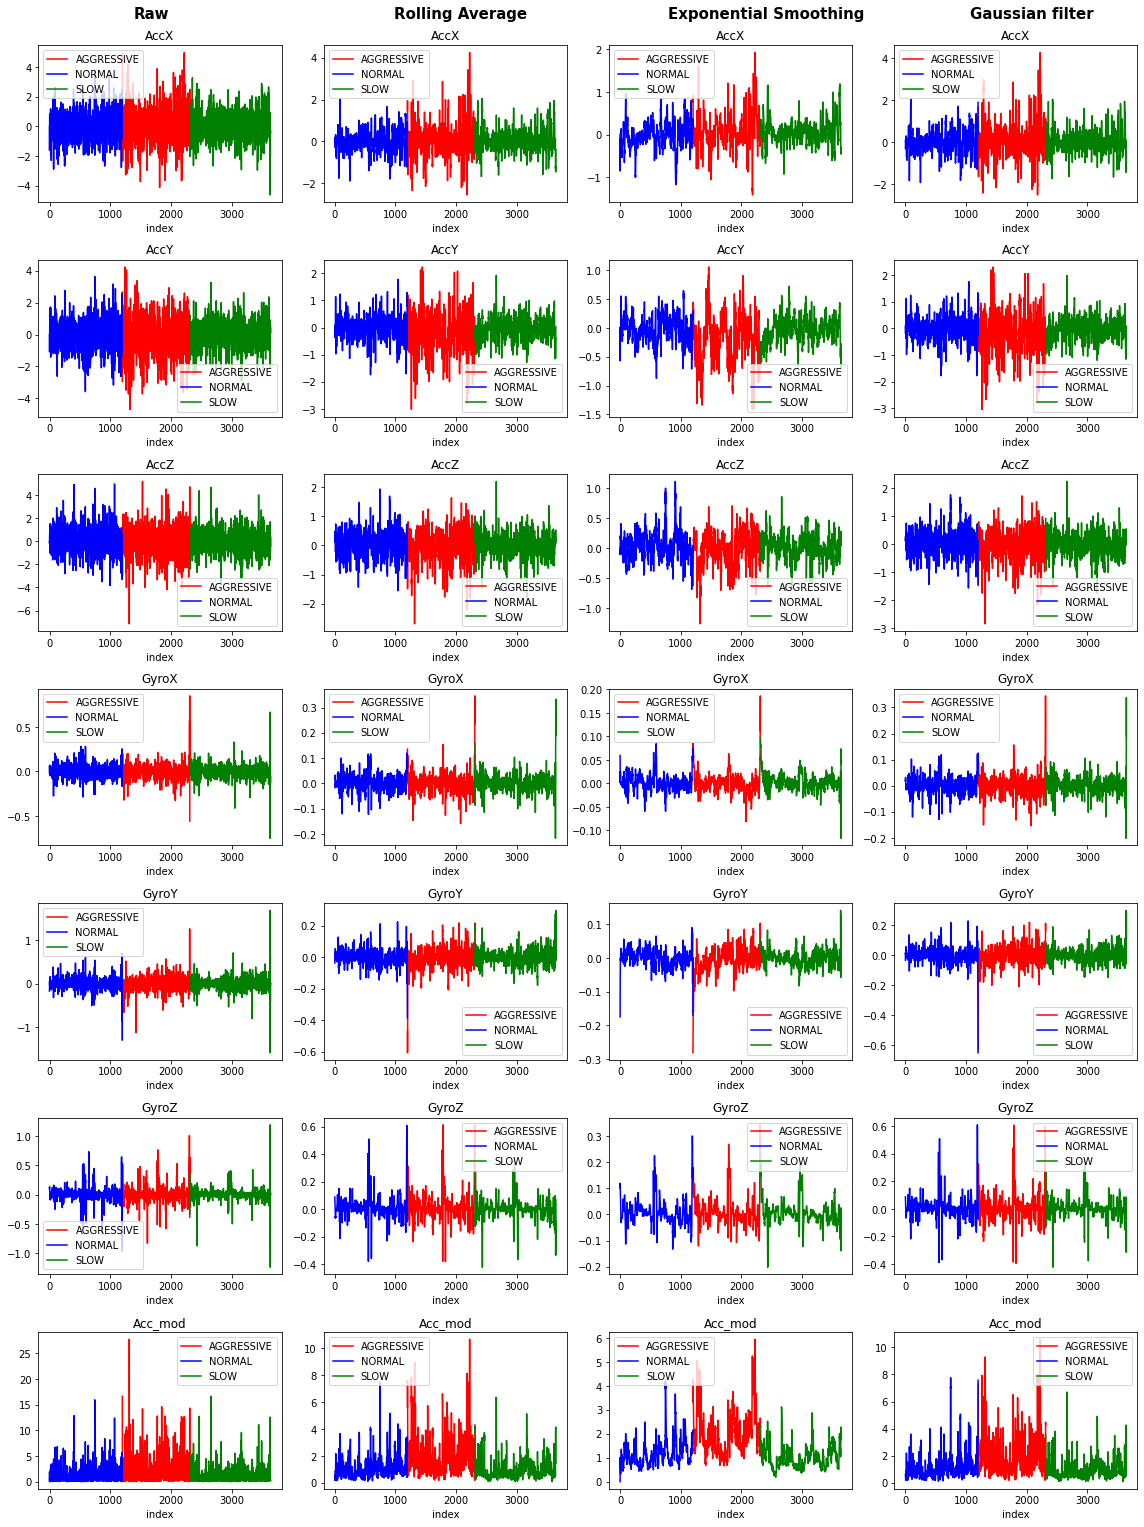

In [59]:
denoised_dfs=[train_data.reset_index()\
              ,rooling_average(train_data,5).reset_index()\
              ,exponential_smoothing(train_data,0.1).reset_index()\
              ,gaussian_smoothing(train_data,5,3).reset_index()\
]
denoise_methods_label=['Raw','Rolling Average','Exponential Smoothing','Gaussian filter']

fig,axes=plt.subplots(len(var_columns),4,figsize=(16,3*len(var_columns)))

for df,(index,label) in zip(denoised_dfs,enumerate(denoise_methods_label)):
    for ax,column in zip (axes[:,index].flatten(),var_columns):
        grouped=df.groupby('Class')
        color={'SLOW':'green','NORMAL':'blue','AGGRESSIVE':'red'}
        for key,group in grouped:
            group.plot(ax=ax,x='index',y=column,label=key,color=color[key])
        ax.set_title(column)
    fig.text(.125-0.002*len(label)+0.25*index,1,label,fontsize=15,weight='bold')
plt.tight_layout()